/var/folders/mr/jb109g2j23g3_lypt1qxvpl40000gn/T/ipykernel_5570/157812245.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


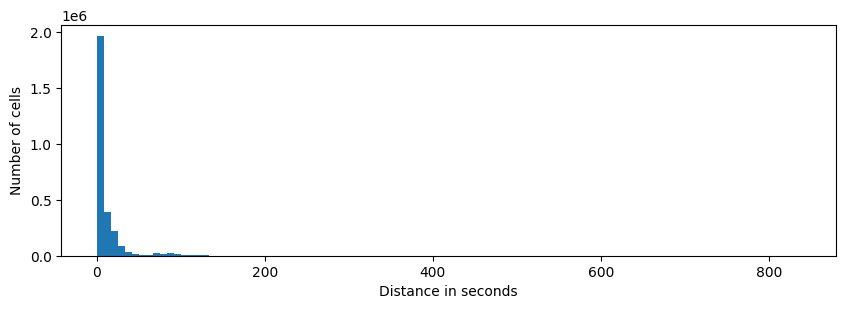

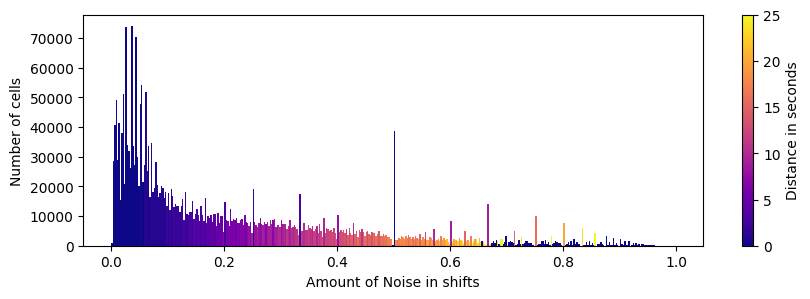

In [8]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

with open('processed_things_2023_12_12.json') as f:
    processed_things = json.load(f)

max_distance = 0
distances = []

noises = []

for thing_name, thing in processed_things.items():
    for day_idx in range(7):
        for hour_idx in range(24):
            if thing["ShiftsFuzzyness"][day_idx][hour_idx] != -1 and thing["Metrics"][day_idx][hour_idx] != -1:
                noises.append(thing["ShiftsFuzzyness"][day_idx][hour_idx])
                distance = thing["Metrics"][day_idx][hour_idx]
                distances.append(distance)
                if distance > max_distance:
                    max_distance = distance
                    

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(distances, bins=100)
ax.set_ylabel('Number of cells')
ax.set_xlabel('Distance in seconds')
ax.set_xlim(0, 25)
fig.show()


                    
fig, ax = plt.subplots(figsize=(10, 3))
bin_size = 0.0025
bin_min = 0
bin_max = 1
median_distance_per_bin = []
distances_per_bin = []
colors = []
color_map = plt.get_cmap('plasma')

for bin_idx in range(int((bin_max - bin_min) / bin_size)):
    distances_per_bin.append([])
for i in range(len(noises)):
    bin_idx = int((noises[i] - bin_min) / bin_size)
    if bin_idx >= 0 and bin_idx < len(distances_per_bin):
        distances_per_bin[bin_idx].append(distances[i])
for _distances in distances_per_bin:
    median_distance_per_bin.append(np.median(_distances))
_, _, patches = ax.hist(noises, bins=np.arange(bin_min, bin_max, bin_size))
for i in range(len(patches)):
    percentage = median_distance_per_bin[i] / 25
    if percentage > 1:
        percentage = 1
    patches[i].set_facecolor(color_map(percentage))
ax.set_ylabel('Number of cells')
ax.set_xlabel('Amount of Noise in shifts')

# Show color bar
norm = Normalize(vmin=0, vmax=25)
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Distance in seconds')

fig.savefig('shifts_histogram.pdf', bbox_inches='tight')


Skipped ratio:  0.38797996696955317


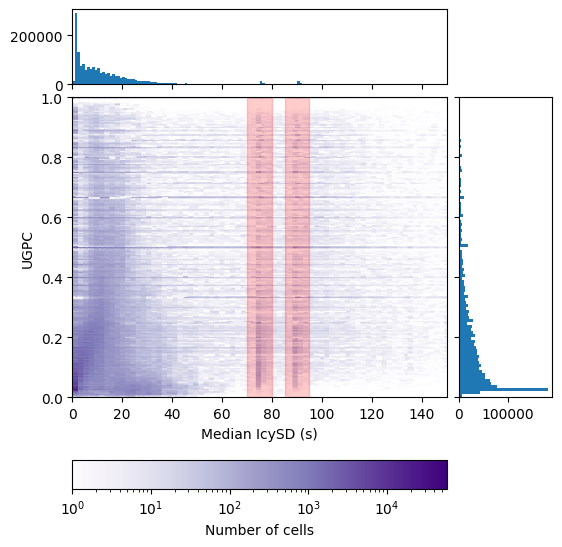

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

with open('processed_things_2023_12_14.json') as f:
    processed_things = json.load(f)
    
noise = []
distances = []

def scatter_hist(x, y, ax, ax_histx, ax_histy, ax_cbar, fig):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    hex_ax = ax.hexbin(x, y, gridsize=400, bins="log", cmap='Purples')
    ax.set_xlabel("Median IcySD (s)")
    ax.set_ylabel("IgpTD")
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 150)
    ax.axvspan(70, 80, color='red', alpha=0.2)
    ax.axvspan(85, 95, color='red', alpha=0.2)
    
    cb = fig.colorbar(hex_ax, cax=ax_cbar, location='bottom')
    cb.set_label('Number of cells')

    # now determine nice limits by hand:
    binwidth_x = 1
    binwidth_y = 0.01
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim_x = (int(xymax/binwidth_x) + 1) * binwidth_x
    lim_y = (int(xymax/binwidth_y) + 1) * binwidth_y

    bins_x = np.arange(-lim_x, lim_x + binwidth_x, binwidth_x)
    bins_y = np.arange(-lim_y, lim_y + binwidth_y, binwidth_y)
    ax_histx.hist(x, bins=bins_x)
    ax_histy.hist(y, bins=bins_y, orientation='horizontal')

skipped_count = 0
total_count = 0
for thing_name, thing in processed_things.items():
    for day_idx in range(7):
        for hour_idx in range(24):
            if thing["Metrics"][day_idx][hour_idx] != -1.0 and thing["ShiftsFuzzyness"][day_idx][hour_idx] != -1.0:
                total_count += 1
                if thing["Metrics"][day_idx][hour_idx] == 0:
                    skipped_count += 1
                    continue
                noise.append(thing["ShiftsFuzzyness"][day_idx][hour_idx])
                distances.append(thing["Metrics"][day_idx][hour_idx])
                
print("Skipped ratio: ", skipped_count / total_count)
                
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=(4, 0.3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
sub_gs_top = gs[0].subgridspec(nrows=2, ncols=2, width_ratios=(4, 1), height_ratios=(1, 4),
                      wspace=0.05, hspace=0.07)
sub_gs_bot = gs[1].subgridspec(nrows=1, ncols=2, width_ratios=(4, 1),
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(sub_gs_top[1, 0])
ax_histx = fig.add_subplot(sub_gs_top[0, 0], sharex=ax)
ax_histy = fig.add_subplot(sub_gs_top[1, 1], sharey=ax)
ax_cbar = fig.add_subplot(sub_gs_bot[0, 0])
# Draw the scatter plot and marginals.
scatter_hist(distances, noise, ax, ax_histx, ax_histy, ax_cbar, fig)

fig.savefig("images/IgpTD_IcySD.pdf", bbox_inches='tight')

